# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1WJpdr1kMSyBuqnLr2a_TyJqce135gxzM?usp=sharing

As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:

!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [4]:
!pip install -U torchtext==0.6 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


If you are interested to use the most recent version if torchtext, you can look at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [6]:
hamEx = False
spamEx = False
for line in open('SMSSpamCollection'):
    if line[0:3]=="ham" and hamEx == False:
        print("Non-spam example: ", line)
        hamEx = True
    else:
        print("Spam example: ", line)
        spamEx = True
    if spamEx == True and hamEx == True:
      break


Non-spam example:  ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Spam example:  ham	Ok lar... Joking wif u oni...



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [7]:
hamCount = 0
spamCount = 0
for line in open('SMSSpamCollection'):
    if line[0:3] =="ham":
      hamCount+=1
    else:
      spamCount+=1


print("Number of spam messages: ", spamCount)
print("Number of non-spam messages: ", hamCount)

Number of spam messages:  747
Number of non-spam messages:  4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

In [7]:
#Two advantages of modelling SMS text messages as sequence of characters:
#1. Avoids issues with unknown words (not in dictionary):
# Since words are made of charaters
#and characters is a fixed set, it is easier to identify spam or not if it is based on characters
#instead of words (which in case new words appears the model may better handle it).
#2. Capable of identifying pattern within the word:
# Non-spam messages may have prefix or suffix or other actual words
# that has pattern inside a full word. By using characters instead of words,
# the model can better undrestand the patterns in shorter words or any internal structures.

#Two disadvantages of modelling SMS text messages as sequence of characters:
#1. Less focused on the notion/connection between words:
# Since every word is broken into characters for interpertation, the model is unable to
#process the actual meaning of the word or sentence. While often in real situation,
#the notion/context of the sentence/message is quite important to understand whether the
#message is a spam or not.

#2. Larger size input:
# The other issue is that compared to modelling use words, individual characters would make
#the input tensor much much larger. When there is a very very long message, this may lead
#to large amount of computations required and it may cause efficiency issues as it would be
#more time consuming.


### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file.

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file.
In our case, the dataset has two fields:

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [8]:
import torchtext

text_field = torchtext.data.Field(sequential=True,
                                  tokenize=lambda x: x,
                                  include_lengths=True,
                                  batch_first=True,
                                  use_vocab=True,
                                  init_token="<BOS>",
                                  eos_token="<EOS>")

label_field = torchtext.data.Field(sequential=False,
                                   use_vocab=False,
                                   is_target=True,
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam'))

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset("SMSSpamCollection", "tsv", fields)

train, val, test = dataset.split(split_ratio=[0.6,0.2,0.2])

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [9]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

#Having a balanced training set helps the model to acquire a holistic view of the
#problem and provide better generalization. This way the model can apply to a wide range
#of similar cases instead of just focused on the specific dataset used to train.
#Furthermore, this also helps to reduce biases as the model could lean to be better at
#the majority class if the dataset used is significantlly unbalanced.
#Therefore, to have a well-performing model it is important to have the dataset balanced.

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [10]:
text_field.build_vocab(train)
#text_field.vocab.stoi -> According to pytorch documentation, it is a dictionary that
#maps the strings(each character) to numercial identifiers.
#text_field.vocab.itos -> According to documentation, it is a list of tokn strings indexed
#by the corresponding numerical identifiers

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

In [11]:
#<unk> represents the unknown words within the text messages (does not exist in the
#vocabulary).
#<pad> represents the characters that are padded to ensure the length of the messages
#are uniform.

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [12]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

val_iter = torchtext.data.BucketIterator(val,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs


In [13]:
for count, batch in enumerate(train_iter, 1):
    max_length = torch.max(batch.sms[1])
    pad_count = -1*torch.sum(batch.sms[1] - max_length)
    #Multiply by -1 to account for the padding being 0 and having negative values
    #after the subtraction

    print("Batch ", count)
    print( "Maximum Length of the Input Sequence:", max_length.item())
    print( "Number of <pad> tokens used in batch:", pad_count.item())
    print()

    if count == 10:
        break

Batch  1
Maximum Length of the Input Sequence: 39
Number of <pad> tokens used in batch: 42

Batch  2
Maximum Length of the Input Sequence: 42
Number of <pad> tokens used in batch: 39

Batch  3
Maximum Length of the Input Sequence: 68
Number of <pad> tokens used in batch: 36

Batch  4
Maximum Length of the Input Sequence: 163
Number of <pad> tokens used in batch: 15

Batch  5
Maximum Length of the Input Sequence: 157
Number of <pad> tokens used in batch: 7

Batch  6
Maximum Length of the Input Sequence: 162
Number of <pad> tokens used in batch: 13

Batch  7
Maximum Length of the Input Sequence: 45
Number of <pad> tokens used in batch: 18

Batch  8
Maximum Length of the Input Sequence: 130
Number of <pad> tokens used in batch: 45

Batch  9
Maximum Length of the Input Sequence: 143
Number of <pad> tokens used in batch: 32

Batch  10
Maximum Length of the Input Sequence: 64
Number of <pad> tokens used in batch: 66



## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [14]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [15]:
class RNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers=1):
        super(RNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, hidden_size)

        self.rnn = nn.GRU(hidden_size, hidden_size, n_layers, batch_first=True)

        self.decoder = nn.Linear(hidden_size, vocab_size)

    def forward(self, input, hidden=None):
        embedded = self.embedding(input)
        output, hidden = self.rnn(embedded, hidden)
        output = self.decoder(output[:, -1, :])
        return output

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [16]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in data:
            inputs, lengths = batch.sms
            labels = batch.label

            outputs = model(inputs)

            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy


### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

In [17]:
def train(model, train_data, val_data, batch_size=1, num_epochs=1, lr=0.001, print_every=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    it = 0
    losses, train_acc, valid_acc = [], [], []
    epochs = []

    for epoch in range(num_epochs):
        for batch in train_data:
            inputs, lengths = batch.sms
            labels = batch.label

            optimizer.zero_grad()
            pred = model(inputs)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()

        losses.append(float(loss))

        epochs.append(epoch)

        train_acc.append(get_accuracy(model, train_data))
        valid_acc.append(get_accuracy(model, val_data))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
            epoch + 1, loss, train_acc[-1], valid_acc[-1]))

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 1; Loss 2.823607; Train Acc 0.606547; Val Acc 0.517489
Epoch 2; Loss 0.810619; Train Acc 0.662754; Val Acc 0.626009
Epoch 3; Loss 0.750528; Train Acc 0.631675; Val Acc 0.730045
Epoch 4; Loss 0.686856; Train Acc 0.672343; Val Acc 0.747085
Epoch 5; Loss 0.526127; Train Acc 0.668044; Val Acc 0.765022
Epoch 6; Loss 0.490888; Train Acc 0.742602; Val Acc 0.800000
Epoch 7; Loss 0.712844; Train Acc 0.769549; Val Acc 0.827803
Epoch 8; Loss 0.529961; Train Acc 0.829724; Val Acc 0.873543
Epoch 9; Loss 0.335820; Train Acc 0.869565; Val Acc 0.916592
Epoch 10; Loss 0.356416; Train Acc 0.899653; Val Acc 0.949776


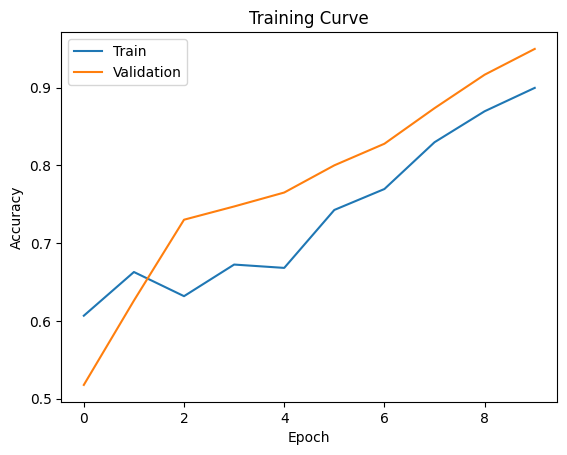

In [18]:
rnn = RNN(len(text_field.vocab), hidden_size=64)
train(rnn, train_iter, val_iter, num_epochs=10, lr=1e-4)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

Epoch 1; Loss 3.778583; Train Acc 0.609853; Val Acc 0.780269
Epoch 2; Loss 2.518917; Train Acc 0.632336; Val Acc 0.736323
Epoch 3; Loss 1.160689; Train Acc 0.582080; Val Acc 0.725561
Epoch 4; Loss 0.949242; Train Acc 0.604893; Val Acc 0.730942
Epoch 5; Loss 0.810898; Train Acc 0.626550; Val Acc 0.720179
Epoch 6; Loss 0.852698; Train Acc 0.605720; Val Acc 0.727354
Epoch 7; Loss 0.766781; Train Acc 0.603240; Val Acc 0.725561
Epoch 8; Loss 0.788084; Train Acc 0.627046; Val Acc 0.730045
Epoch 9; Loss 0.737578; Train Acc 0.648041; Val Acc 0.730942
Epoch 10; Loss 0.707389; Train Acc 0.658952; Val Acc 0.734529


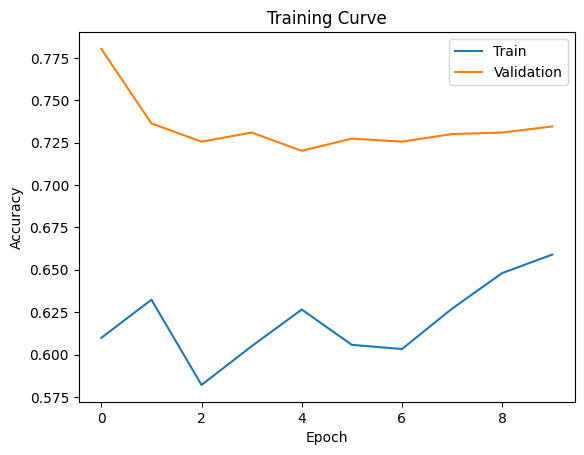

In [29]:
#The previous model showed train_acc around 0.90 and val_acc around 0.95 which
#is pretty good.
#The new value for hidden_size is changed to 32 compared to original value of 64.
#The value for num_epochs and learning rate are held unchanged as 10 and 1e-4.
rnn1 = RNN(len(text_field.vocab), hidden_size=32)
train(rnn1, train_iter, val_iter, num_epochs=10, lr=1e-4)

#The final train_acc decreased to 0.66 and val_acc decreased to 0.73 with the
#hyperparameter value choices.
#The model did not perform better compared to the original, demonstrating that
#decreasing the hidden_size decreased the model's capabilities. Therefore, I would
#continue to try tune the hidden_size by increasing it to improve the performance.

Epoch 1; Loss 1.101584; Train Acc 0.670855; Val Acc 0.738117
Epoch 2; Loss 0.608960; Train Acc 0.743263; Val Acc 0.802691
Epoch 3; Loss 0.454848; Train Acc 0.800463; Val Acc 0.893274
Epoch 4; Loss 0.363129; Train Acc 0.889569; Val Acc 0.919283
Epoch 5; Loss 0.078907; Train Acc 0.938668; Val Acc 0.956054
Epoch 6; Loss 0.098072; Train Acc 0.925938; Val Acc 0.961435
Epoch 7; Loss 0.041400; Train Acc 0.960324; Val Acc 0.962332
Epoch 8; Loss 0.045057; Train Acc 0.968425; Val Acc 0.969507
Epoch 9; Loss 0.060842; Train Acc 0.969747; Val Acc 0.964126
Epoch 10; Loss 0.102144; Train Acc 0.972557; Val Acc 0.978475


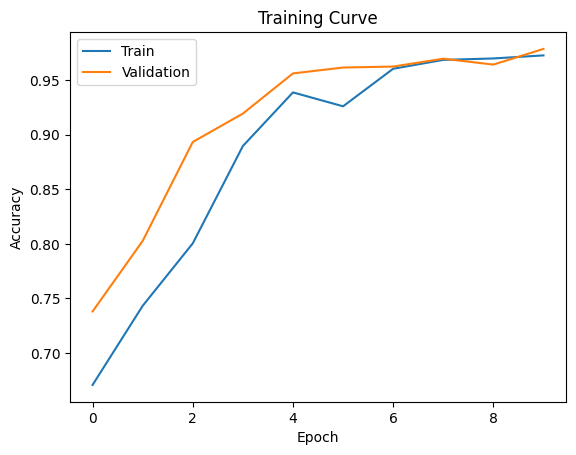

In [20]:
#Num_epochs and learing rate are both held unchanged as 10 and 1e-4, but
#since decreasing the hidden_size did not improve the performance of the model,
#I tried to double the hidden_size value compared to the default 64 which is now set to 128.
rnn2 = RNN(len(text_field.vocab), hidden_size=128)
train(rnn2, train_iter, val_iter, num_epochs=10, lr=1e-4)

#The model performed verhy well with train_acc reaching 0.97 and val_acc reaching 0.98
#as the final result. This gradual increase and minimal difference between the train and val
#accuracy also shows that the model has been performing very well.
#I would like to tune the learning rate as the next hyperparameter to
#examine the effects of learning rate on the model's performance.

Epoch 1; Loss 0.173293; Train Acc 0.945446; Val Acc 0.934529
Epoch 2; Loss 0.141315; Train Acc 0.923954; Val Acc 0.895964
Epoch 3; Loss 0.016495; Train Acc 0.965945; Val Acc 0.973094
Epoch 4; Loss 0.010878; Train Acc 0.989750; Val Acc 0.973991
Epoch 5; Loss 0.005495; Train Acc 0.983303; Val Acc 0.979372
Epoch 6; Loss 0.007012; Train Acc 0.994049; Val Acc 0.971300
Epoch 7; Loss 0.014754; Train Acc 0.997686; Val Acc 0.981166
Epoch 8; Loss 0.003123; Train Acc 0.999669; Val Acc 0.982960
Epoch 9; Loss 0.001464; Train Acc 0.999669; Val Acc 0.982063
Epoch 10; Loss 0.000177; Train Acc 0.999835; Val Acc 0.982960


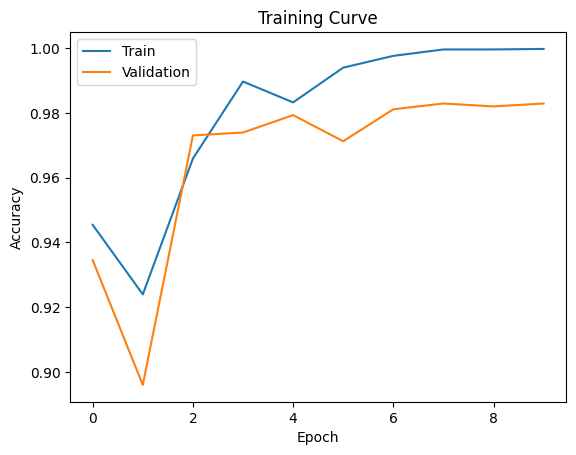

In [21]:
#The new model's hidden_size and num_epochs were held to be 128 and 10 (unchanged),
#the new learning rate experimented is 1e-3.

rnn3 = RNN(len(text_field.vocab), hidden_size=128)
train(rnn3, train_iter, val_iter, num_epochs=10, lr=1e-3)

#The model performs very well with train_acc reaching 0.99 and val_acc reaching 0.98
#between the two curves, but throughout the training the discrepancies between train and val dataset
#is about 1% which is matching pretty well. This shows that increasing the learning rate
#in the case of this model did not significantly change the model's performance.

Epoch 1; Loss 1.150303; Train Acc 0.638783; Val Acc 0.732735
Epoch 2; Loss 0.595257; Train Acc 0.746735; Val Acc 0.782960
Epoch 3; Loss 0.533795; Train Acc 0.809225; Val Acc 0.869058
Epoch 4; Loss 0.359677; Train Acc 0.868408; Val Acc 0.911211
Epoch 5; Loss 0.089896; Train Acc 0.934865; Val Acc 0.951570
Epoch 6; Loss 0.096847; Train Acc 0.950074; Val Acc 0.960538
Epoch 7; Loss 0.145960; Train Acc 0.963465; Val Acc 0.951570
Epoch 8; Loss 0.021996; Train Acc 0.968755; Val Acc 0.959641
Epoch 9; Loss 0.051972; Train Acc 0.972888; Val Acc 0.970404
Epoch 10; Loss 0.031501; Train Acc 0.973715; Val Acc 0.973094
Epoch 11; Loss 0.022655; Train Acc 0.979666; Val Acc 0.970404
Epoch 12; Loss 0.153131; Train Acc 0.977848; Val Acc 0.965919
Epoch 13; Loss 0.109070; Train Acc 0.984130; Val Acc 0.975785
Epoch 14; Loss 0.029878; Train Acc 0.957018; Val Acc 0.978475
Epoch 15; Loss 0.061600; Train Acc 0.978178; Val Acc 0.967713
Epoch 16; Loss 0.009482; Train Acc 0.984130; Val Acc 0.976682
Epoch 17; Loss 0.

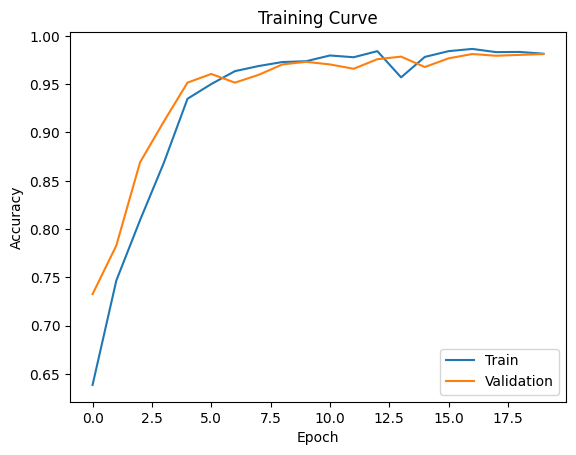

In [22]:
#Since the learning rate was adjusted but epochs were unchanged,
#I plan to increase the num_epochs to examine the impacts of tuning this hyperparameter.
#The learning rate was adjusted back to 1e-4 and hidden size to be 128 (that gave good accuracies),
#and number of epochs increased to 20
rnn4 = RNN(len(text_field.vocab), hidden_size=128)
train(rnn4, train_iter, val_iter, num_epochs=20, lr=1e-4)


#As shown in the train_acc reaching 0.98 and val_acc reaching 0.98 too, I believe this
#is considered the best model with almost no difference throughout the training stage.
#Sometimes, the val_acc is even higher than train_acc, showing that the RNN model is
#not overfitting on the training set by any chance. This increase in number of epochs also
#ensured that the model's performance is very stable.

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [23]:

valid_spam = torchtext.data.Dataset(
    [e for e in val.examples if e.label == 1],
    val.fields)

valid_nospam = torchtext.data.Dataset(
    [e for e in val.examples if e.label == 0],
    val.fields)

val_spam_iter = torchtext.data.BucketIterator(valid_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

val_nospam_iter = torchtext.data.BucketIterator(valid_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

In [24]:
false_positive_rate = get_accuracy(rnn4, val_nospam_iter)
false_negative_rate = get_accuracy(rnn4, val_spam_iter)

print("The false-positive rate is: ", 1-false_positive_rate)
print("The false_negative rate is: ", 1-false_negative_rate)

The false-positive rate is:  0.007329842931937169
The false_negative rate is:  0.09375


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

In [25]:
#False-positive is when the non-spam message is classified as a spam message.
#The issue with a high false-positive is that if the model is deployed on phone
#is that the user may often miss the important messages as they are classified as spam
#and potentially sorted into the spam folder instead of the correct message inbox.

#False-negative is when the spam message is classified as a non-spam message.
#The issue with a high false-negative is that if the model is deployed on phone
#is that the user could likely be receiving a lot of spam messages or malicious contents
#that may be attempted to conduct fraud. This may be annoying to the user as they have
#to spend extra time cleaning the message and carefully identify if the message is a spam or not manually.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [26]:
test_iter = torchtext.data.BucketIterator(test,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

test_acc = get_accuracy(rnn4, test_iter)
print("The best performing model's test accuracy is: ", test_acc*100, "%")

The best performing model's test accuracy is:  98.74326750448833 %


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [27]:
test_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)

test_spam_iter = torchtext.data.BucketIterator(test_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

test_nospam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

test_nospam_iter = torchtext.data.BucketIterator(test_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
false_positive_rate = get_accuracy(rnn4, test_nospam_iter)
false_negative_rate = get_accuracy(rnn4, test_spam_iter)

print("The false-positive rate is: ", 1-false_positive_rate)
print("The false_negative rate is: ", 1-false_negative_rate)

The false-positive rate is:  0.007157464212678932
The false_negative rate is:  0.05882352941176472


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [28]:
msg = "machine learning is sooo cool!"

index = []
for char in msg:
    index.append(text_field.vocab.stoi[char])

output = rnn(torch.tensor(index).unsqueeze(0))

probabilities = F.softmax(output, dim=1)

spam_prob = probabilities[:, 1].item()

if spam_prob >= 0.5:
    print("The prediction probability is: ",spam_prob*100, "%")
    print("This message is a spam!")
else:
    print("The prediction probability is: ", spam_prob*100, "%")
    print("This message is a real message not a spam!")


The prediction probability is:  42.38826930522919 %
This message is a real message not a spam!


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

In [28]:
#I believe that spam detecting is a very difficult task since the invention of new
#vocabularies and manipulation of context when people are talking through text makes it
#even harder to detect whether a message is a spam or not. Therefore, the vocabulary
#would need to be updated very frequently which is difficult. Furthermore, the dataset
#for training would need to be renewed very frequently for the above reason too.
#Overall, being able to accuractely detect a spam, especially longer messages that
#are similar to normal but are actually spam with the ambiguous definition of spam messages
#seem to be quite a difficult task.


#Furthermore, I would build a baseline model that uses a list of words that are
#most commonly seen in spam messages (including symbols and emoticons).
#This becomes the indicator that if the message contains maybe two or three of the words
#then it has exceeded the "threshold" and is considered as a spam message (normalized as 0 or 1).
#Although this would definitely not be as accurate as an actual RNN model,
#it is much eaiser to build and run which could be used as a simple baseline
#to ensure that our RNN's performance at least exceeds this accuracy.